
# Assignment 2: Decision Tree in Rust (with PyO3 & scikit-learn)

Welcome to Assignment 2, where you’ll build on your Rust knowledge and explore integrating Python and Rust for AI tasks. You will:

1. Implement a Decision Tree classifier from scratch in Rust.
2. Compare results to scikit-learn’s Decision Tree using PyO3 calls.

**Deliverables**:
- A Rust library that implements your decision tree.
- A binary (CLI) that can train/test the tree on a CSV dataset.
- This notebook (`assignment_2.ipynb`) showing how you generated data, called Rust code, and compared results.


## Usage of AI Coding Assistant

Usage of AI Coding Assistant is permitted to assist in completing the assignment under the following conditions:

1. The code suggestions provided by the AI Coding Assistant can be used to understand the Rust programming language and complete the assignment. However, it is not allowed to copy the code produced by the AI Coding Assistant (as it is) and submit it as the solution to the assignment. You should try to understand the code suggestions and write your own code.

2. The usage of any AI Coding Assistant must be acknowledged and disclosed in the submission by writing information about the model used, the prompt(s) used to generate the code, and the parts of the code written by the AI Coding Assistant.

## AI Coding Assistant Usage Disclosure

In case you used an AI Coding Assistant to help you in completing this assignment, it is required to write a disclosure about the model used, the prompts used to generate the code, and the parts of the code generated by the AI Coding Assistant.

**Please note that using AI Coding Assistant would not affect your grade in any way as long as you disclose the required information.**

[# Write your disclosure here if applicable]

--------------------

## 1. Environment Setup & Verification

In this section, you’ll verify your environment, just like in Assignment 1.

**Steps/Notes**:
- Check if Python, Rust, Cargo, and scikit-learn are installed.
- Possibly remind students to set up a new virtual environment for Python.
- Mention any required crates: e.g., `[dependencies] pyo3 = "0.23.4"`
- Make sure to use Python 3.10+ for PyO3 compatibility.

In [ ]:
# Example shell commands:
!cargo --version
!rustc --version

# Check Python packages:
!python --version
!pip show scikit-learn

cargo 1.90.0 (840b83a10 2025-07-30)
rustc 1.90.0 (1159e78c4 2025-09-14)
Python 3.12.12
Name: scikit-learn
Version: 1.7.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License-Expression: BSD-3-Clause
Location: /Users/marconms/dev/uni/effairustwise25/.venv/lib/python3.12/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 
Name: rustdt
Version: 0.1.0
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: /Users/marconms/dev/uni/effairustwise25/.venv/lib/python3.12/site-packages
Editable project location: /Users/marconms/dev/uni/Training-ML-with-Rust
Requires: 
Required-by: 


# 2. Implementing a Decision Tree in Rust

# 2.1. Core requirements

Implement the following core functionalities for a Decision Tree classifier in a Rust project (not here in the notebook):
1. Tree Building: A function (e.g., fit()) that constructs the decision tree from training data.
2. Prediction: A function (e.g., predict()) that, given a vector of features, returns a predicted label or probability distribution.

# 3. Comparison with Scikit-learn

Implement the similar functions as scikit-learn DecisionTreeClassifier that use your Rust implementation using PyO3 bindings then compare it with scikit-learn performance (runtime for both training and inference) and accuracy. Write code in Python the does the following:
1. Load a dataset.
2. Run scikit-learn DecisionTreeClassifier on the dataset.
3. Run your Rust Decision Tree on the same dataset.
4. Store the results.
5. Compare the results across implementations and datasets in a table and suitable plots.
6. Write a short summary of the comparison.

Use the following dataset for comparison (check [here](https://scikit-learn.org/stable/datasets/real_world.html) for loading instructions):
- fetch_covtype
- adult (use fetch_openml('adult', version=2))
- fetch_kddcup99

Raw results

   dataset    model  train_time  infer_time  accuracy  n_samples_train  \
0  covtype  sklearn    0.162847    0.001202  0.749520            37500   
1  covtype     rust  145.666657    0.077236  0.749520            37500   
2    adult  sklearn    0.116218    0.001083  0.859389            36631   
3    adult     rust   83.875254    0.142387  0.857997            36631   

   n_samples_test  n_features  
0           12500          54  
1           12500          54  
2           12211         108  
3           12211         108  

Accuracy by dataset and model

model        rust   sklearn
dataset                    
adult    0.857997  0.859389
covtype  0.749520  0.749520

Training time (s) by dataset and model

model          rust   sklearn
dataset                      
adult     83.875254  0.116218
covtype  145.666657  0.162847

Inference time (s) by dataset and model

model        rust   sklearn
dataset                    
adult    0.142387  0.001083
covtype  0.077236  0.0012

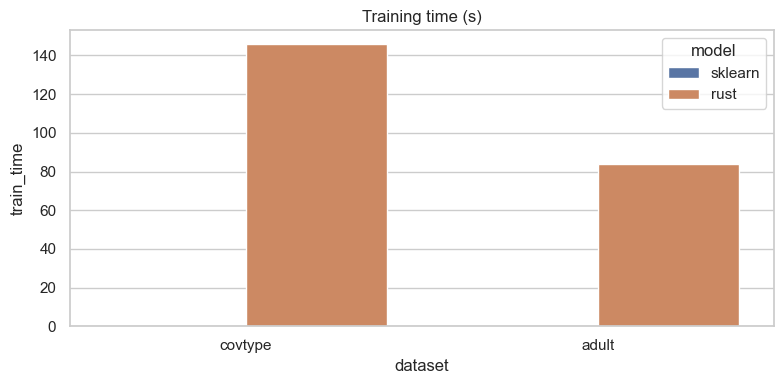

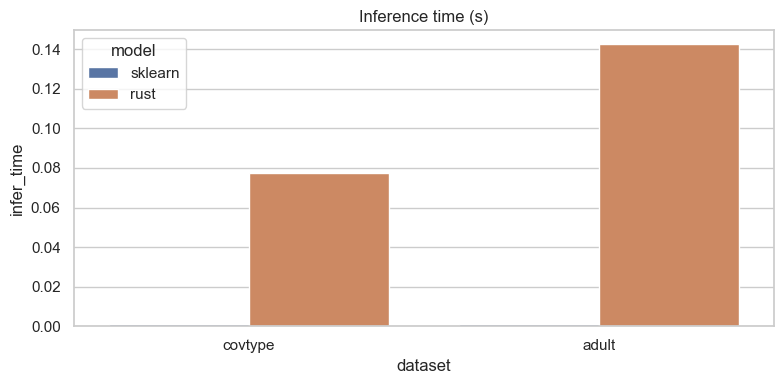

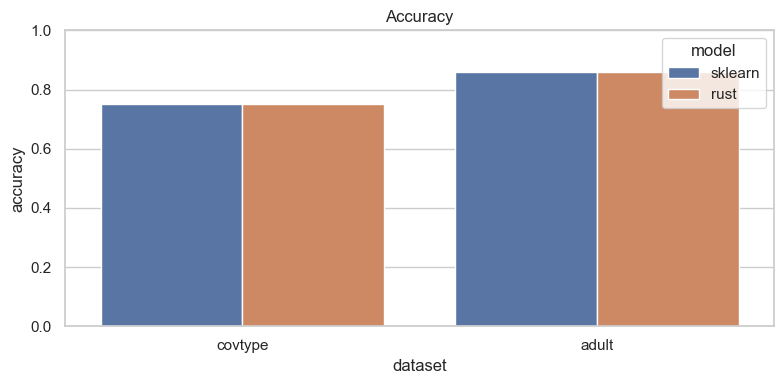

In [ ]:
!python benchmark.py

[Short summary here]

# 4. Submission

**What to submit**: (all in one zip file named: `EffAIRust_assignment_2_Team_[TeamID].zip`):
1. Your completed Rust project (with `Cargo.toml`, `src/`, tests, etc.).
2. This notebook (`assignment_2.ipynb`), so we can see your test results.

Submit the assignment as a ZIP file to Moodle.